# 2022 Capstone Project 
# Where can soil moisture improve rainfall-triggered landslide predictability?
## Student: Jacquelyn Witte
## Mentor: Elsa Culler (CU/CIRES)

In [1]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import folium
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

from geopandas import GeoDataFrame
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.2)
#sns.set(font_scale=1.2, style="whitegrid")

%matplotlib inline

## Why do we care about landslides?


Landslides have significant economic impacts. There can be loss of life, wildlife and wildlife habitat. Landslides are a serious geologic hazard common to many areas in the US and Canada. In Colorado, which is where I live, a high percentage of our population lives in the Rockies. So transportation and infrastructure are impacted as you can see from the CNN caption below of a mudslide event on the I-70 which is our main highway artery across the Rockies.

<div>
<img src="images/cnn_newsarticle_glenspringsLandslideCO.png " width="500"/>
</div>



On another note, my husband I were driving home from the Oregon coast during an Atmospheric river event and there were crews along the valley roads building retaining walls to prevent landslides because of the soil erosion caused by wildfires in that region. So climate change is also factor and one which confounds our ability to predict rainfall trigger landslides. Climate change is a chaotic system and the basis of all models is pattern and order. 

This is where soil moisture and composition and knowing the history of the area and land-uses come into play in this project. 

## Motivation and Approach

Landslides have multiple causes:  rainfall, snowmelt, erosion, earthquakes, volcanoes, disturbance by human activities, or any combination of these and other factors. This study focuses on rainfall-triggered landslides. Predicting them with a high degree of accuracy to save lives and maintain infrastructure is challenging. Precipitation data sources are heterogeneous - radar, satellite, in-situ and ensemble model predictions using available precipitation products carry large uncertainties (https://onlinelibrary.wiley.com/doi/full/10.1002/hyp.14260). This make it challenging to predict the timing, severity, extent, and even likelihood that a landslide will occur. 

Soil moisture can be a potential indicator of the type of rainfall induced landslide. We can use soil moisture data to group landslides into two types (1) shallow slope failures - saturation induced by rainfall infiltration and (2) run off driven landslides - triggered by intense storms.  This informs the forecaster which models and precipitation products are optimal to use to better predict a landslide event.

The purpose of this study is to address the need to improve our understanding of landslides caused by rainfall by 
- Examining the relationship between soil moisture and precipitation during landslide events. 
- Using soil moisture as an accuracy indicator for triggering landslide events.
- Quantify landslide predictability using soil moisture, i.e. does adding soil moisture information improve the predictions?


This work follows ongoing research done by Elsa Culler and colleagues in their paper:
> Culler, E. S., Badger, A. M., Minear, J. T., Tiampo, K. F., Zeigler, S. D., & Livneh, B. (2021). A multi-sensor evaluation of precipitation uncertainty for landslide-triggering storm events. Hydrological Processes, 35( 7), e14260. https://doi.org/10.1002/hyp.14260

## Study region: Colorado, USA

The study area will be Colorado, because I live here and am somewhat familiar with the landscape. 

Towns and cities in Colorado's mountainous or hilly terrain are growing and spreading as populations move into these popular destination areas. It is important to understand the potential exposure to landslide hazards, and how counties can maintain optimal land-use and infrastructure to reduce the costs of living with landslides. 

Below is map of the Colorado with all the Landslide events between 2007-2016. The locations are color coated by trigger - Continuous rain, downpour, rain, tropical cyclone which we have one documented and unknown.
> Data Source: Global Landslide Catalog https://doi.org/10.1002/hyp.14260

In [2]:
# Change to data directory
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

# Read Global Landslide Catalog CSV to a dataFrame
glc = pd.read_csv(os.path.join('capstone', 
                               'landslide', 
                               'nasa.glc.export.csv'))
# Subset to Colorado and remove non-rainfall events
glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# Convert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()

# Georeference the locations to plot on Folium
geometry = [Point(xy) for xy in zip(glc_co['longitude'], glc_co['latitude'])]
crs = 'epsg:4326'
glc_co_epsg4326 = GeoDataFrame(glc_co, crs=crs, geometry=geometry)

# Create a symbology dictionary that maps "type" to color. 
triggers = np.unique(glc_co_epsg4326['landslide_trigger'])
colors = ['red', 'green', 'blue', 'orange','lightgray']
points_symb = dict(zip(triggers,colors))

# ------- Map the Landslide events -----------------------------
# Create Title
loc = 'Rainfall-triggered Landslides in Colorado (2007 - 2016)'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

m2 = folium.Map([39.0, -105.27], zoom_start=7, tiles='Stamen Terrain')

for i, loc in glc_co_epsg4326.iterrows():
    folium.Marker(location=[loc['latitude'], loc['longitude']],
                  icon=folium.Icon(color=points_symb[loc['landslide_trigger']],
                                   prefix='glyphicon', icon='off')).add_to(m2)
    
Dict = {'cr': {'raintype': 'Continuous Rain',
            'loc': [40.5, -103],
            'color': 'red',
            'textloc': [40.5, -102.7]},
        'dp': {'raintype': 'Downpour',
            'loc': [40, -103],
            'color': 'green',
            'textloc': [40, -102.7]},
        'rain': {'raintype': 'Rain',
            'loc': [39.5, -103],
            'color': 'blue',
            'textloc': [39.5, -102.7]},
        'tc': {'raintype': 'Tropical Cyclone',
            'loc': [39., -103],
            'color': 'orange',
            'textloc': [39., -102.7]},
        'un': {'raintype': 'Unknown',
            'loc': [38.5, -103],
            'color': 'lightgray',
            'textloc': [38.5, -102.7]},
        }
    
for key in Dict.keys():
    folium.CircleMarker(location=Dict[key]['loc'], radius=10,
                        color=Dict[key]['color'],
                        fill_color=Dict[key]['color'],
                        fill_opacity=1.0).add_to(m2)
    folium.Marker(
        location=Dict[key]['textloc'],
        icon=folium.DivIcon(
            html=f"""<b>{Dict[key]['raintype']}</b>""")
    ).add_to(m2)

#Add Title
m2.get_root().html.add_child(folium.Element(title_html))
m2

## Data Sources

#### [NASA Global Landslide Catalog (2007-2016)](https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog/h9d8-neg4)
> Kirschbaum, D. B., Adler, R., Hong, Y., Hill, S., & Lerner-Lam, A. (2010). A global landslide catalog for hazard applications: Method, results, and limitations. Natural Hazards, 52(3), 561–575. https://doi.org/10.1007/s11069-009-9401-4

The Global Landslide Catalog (GLC) was developed with the goal of identifying rainfall-triggered landslide events around the world, regardless of size, impacts or location. The GLC considers all types of mass movements triggered by rainfall, which have been reported in the media, disaster databases, scientific reports, or other sources. The GLC has been compiled since 2007 at NASA Goddard Space Flight Center.

Elsa Culler (CIRES/CU Boulder) and colleagues provided a subset of landslide locations verified with ancillary satellite imagery.

#### [Groundwater and Soil Moisture Conditions from GRACE Data Assimilation L4 7-days 0.125 x 0.125 degree V4.0 (GRACEDADM_CLSM0125US_7D)](https://disc.gsfc.nasa.gov/datasets/GRACEDADM_CLSM0125US_7D_4.0/summary?keywords=GRACE)

> Matthew Rodell and Hiroko Kato Beaudoing, NASA/GSFC/HSL (2021),
Groundwater and Soil Moisture Conditions from GRACE Data Assimilation L4 7-days 0.125 x
0.125 degree Version 4.0, Greenbelt, Maryland, USA: Goddard Earth Sciences Data and
Information Services Center (GES DISC), Accessed 22 April 2022, https://doi.org/10.5067/UH653SEZR9VQ.

- Shortname:GRACEDADM_CLSM0125US_7D
- Longname:Groundwater and Soil Moisture Conditions from GRACE Data Assimilation L4 7-days 0.125 x 0.125 degree V4.0
- DOI:10.5067/UH653SEZR9VQ
- Version:4.0
- Format:netCDF
- Spatial Coverage:-125.0,25.0,-67.0,53.0
- Temporal Coverage:2002-04-01 to  2022-01-02
- File Size:1 MB per file
- Data Resolution
- Spatial:0.125 ° x 0.125 °
- Temporal:7 days

#### [SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 7](https://nsidc.org/data/SPL3SMP/versions/7)
> O'Neill, P. E., S. Chan, E. G. Njoku, T. Jackson, R. Bindlish, and J. Chaubell. 2020. SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 7. [Indicate subset used]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center, Accessed 22 April 2022, doi: https://doi.org/10.5067/HH4SZ2PXSP6A. 

This Level-3 (L3) soil moisture product provides a composite of daily estimates of global land surface conditions retrieved by the Soil Moisture Active Passive (SMAP) passive microwave radiometer. SMAP L-band soil moisture data are resampled to a global, cylindrical 36 km Equal-Area Scalable Earth Grid, Version 2.0 (EASE-Grid 2.0).

#### [GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 degree V06 (GPM_3IMERGDL)](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGDL_06/summary?keywords=%22IMERG%20late%22)
> Huffman, G.J., E.F. Stocker, D.T. Bolvin, E.J. Nelkin, Jackson Tan (2019), GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 degree V06, Edited by Andrey Savtchenko, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: 18 April 2022, https://doi.org/10.5067/GPM/IMERGDL/DAY/06

- Shortname:GPM_3IMERGDL
- Longname:GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 degree V06
- DOI:10.5067/GPM/IMERGDL/DAY/06
- Version:06
- Format:netCDF
- Spatial Coverage:-180.0,-90.0,180.0,90.0
- Temporal Coverage:2000-06-01 to  2022-04-20
- File Size:12 MB per file
- Data Resolution
- Spatial:0.1 ° x 0.1 °
- Temporal:1 day

#### [ESA Climate Change Initiative soil moisture version 03.3](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-soil-moisture?tab=overview)
> R. van der Schalie, R. De Jeu, C. Paulik, W. Dorigo, C. Reimer, R. Kidd, 2017. C3S D312a
Lot 7.Algorithm Theoretical Basis Document (ATBD): Soil Moisture

> Dorigo, W.A., Gruber, A., De Jeu, R.A.M., Wagner, W., Stacke, T., Loew, A.,
Albergel, C., Brocca, L., Chung, D., Parinussa, R.M., Kidd, R. (2015). Evaluation of
the ESA CCI soil moisture product using ground-based observations. Remote
Sensing of Environment; 162, 380-395, doi: https://doi.org/10.1016/j.rse.2014.07.023.
> 

The "active" and "passive" products were created by using scatterometer and radiometer soil moisture products, respectively. The "combined" product results from a blend based on the two previous products.

This dataset is produced on behalf of the Copernicus Climate Change Service (C3S).

# Preliminary Observations

## NASA SMAP soil moisture initiated at co-located with Colorado Landslide events

In [3]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_AM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[4]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

In [4]:
def colocate_gpm_to_landslide(glc_df, data_xr, periods=7):
    """
    Returns a dataframe of precipitation values colocated to a landslide event.
    
    Based on the Global Landslide Catalog as input.
    Define the number of day to retrieve a precipitation value leading up
        to a landslide event.
        
    Parameters 
    ----------
    
    glc_df: pandas.core.frame.DataFrame
        The GLC dataframe
    
    data_xr: xarray.core.dataset.Dataset
        The GPM precipitation data, either single or multi day events
        
    period: int
        Number of periods to generate. Default is 7 days.

    Returns
    -------
    df: pandas.core.frame.DataFrame 
    """

    gpm_ts_list = []
    for i, date in enumerate(glc_df.index):
        precip = data_xr['precipitationCal'].sel(indexers={
            'time': pd.date_range(date, periods=periods, freq='-1D'),
            'lon': glc_df.longitude[i],
            'lat': glc_df.latitude[i]},
            method="nearest")
        gpm_ts_list.append(precip)
        gpm_ts_list[i]['landslideID'] = glc_df.event_id[i]
        gpm_ts_list[i]['landslideDate'] = date

    gpm_ts_xr = xr.concat(gpm_ts_list,
                          dim='landslideID',
                          fill_value=np.nan,
                          join='override')
    
    df = gpm_ts_xr.to_dataframe()
    df = df.reset_index(level=[1])
    # Remove unnecessary columns
    df.pop('lat')
    df.pop('lon')
    df.pop('time')
    
    return df

In [5]:
def add_count(df, days, var):
    """
    Adds a countdown column from N number of days to the Landslide event.
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
    
    days: int
        Where 0 is the landslide event

    var: String
        The column name

    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """

    cnts = []
    accum = []
    ndays = np.arange(days)+1
    ndays = np.arange(start=-days, stop=0, step=1)
    for i in range(0, int(len(df[var])/days)): 
        cnts.extend(ndays)

    df['days-to-landslide'] = cnts
    return df

In [6]:
def cumulative_var(df, var):
    """
    Add a column of accumulated variables amounts.
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
    
    var: String
        The column name

    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """
    
    accum = []
    for i, data in df.groupby('landslideID'):
        accum.extend(data[var].cumsum().values)

    df[var+'_accum'] = accum
    return df

#### Subset the Colorado Landslide > 2015 which is when SMAP started measuring

In [7]:
glc_co_gt2015 = glc_co[glc_co.index > '2015-01-01']
#glc_co_gt2015.head()

#### Find SMAP data files, sorted

In [8]:
data_dir = os.path.join('capstone', 'smap_l3')
smap_files = sorted(glob(os.path.join(data_dir, '*.h5')))

#### Load the NSIDC EASE2 grid lon and lat datasets. You need these to do any subsetting with SMAP data.

In [9]:
# Reshape to dimensions of the SMAP data above
sm_data, date = read_smap(smap_files[0], 26)
lats = np.fromfile(os.path.join(data_dir, 'EASE2_M36km.lats.964x406x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'EASE2_M36km.lons.964x406x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)

#### Each SMAP file contains variables that are useful to this study. Let's focus on soil moisture.
| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 26 | cm<sup>3</sup>/cm<sup>3</sup> |
| albedo | 2 | N/A |
| clay_fraction | 8 | N/A |
| surface_temperature | 33 | K |
| vegetation_opacity | 48 | N/A |
| vegetation_water_content | 52 | kg/m<sup>2</sup> |

#### Calculate the mean SMAP soil moisture going back 30 days from each Landslide event

In [10]:
# Initialize an empty data Frame
soilm_df = pd.DataFrame()

periods = 30
for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):

    # Initialize empty arrays
    sm_date = []
    sm_data_3d = np.empty([sm_data.shape[0], sm_data.shape[1], periods])

    # Generate dates going back 30 days from the landslide
    glc_date = pd.date_range(ls_date, periods=periods,
                             freq='-1D').strftime('%Y%m%d')

    # Loop over 30 days from the event
    t = 0
    for dd in glc_date:
        # Find the SMAP file
        file = [x for x in smap_files if re.findall(dd, x)]

        # Retrieve the variables
        # Remember soil moisture = index 26
        sm_data_3d[:, :, t], time_t = read_smap(file[0], 26)
        sm_date.append(time_t)
        t += 1

    # Take the +/- 0.5 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.25
    S_lat = glc_co_gt2015.latitude[i]-0.25
    W_lon = glc_co_gt2015.longitude[i]-0.25
    E_lon = glc_co_gt2015.longitude[i]+0.25

    # Subset the data and assign the mean value
    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
    sm_mean = np.empty([periods])
    for j in np.arange(0, sm_data_3d.shape[2]):
        sm_2d = sm_data_3d[:, :, j]
        sm_mean[j] = np.nanmean(sm_2d[subset])

    # Create a pandas series
    smData = {'sm': sm_mean}
    sm = pd.DataFrame(smData)
    sm['sm_date'] = sm_date
    sm['landslideID'] = glc_co_gt2015.event_id[i]
    sm = sm.set_index('landslideID')

    # Update the dataFrame
    soilm_df = soilm_df.append(sm)

#### Add a count of 30 days of soil moisture measurements for each landslide event. This will help in plotting.

In [12]:
soilm_df = add_count(soilm_df, periods, 'sm')

#### Add a new column of the cumulative amounts per landslide event

In [13]:
soilm_df = cumulative_var(soilm_df, 'sm')
soilm_df.head()

,sm,sm_date,days-to-landslide,sm_accum
landslideID,,,,
6994,0.198225,2015-05-11,-30,NaN
6994,NaN,2015-05-10,-29,0.111532
6994,0.201068,2015-05-09,-28,NaN
6994,NaN,2015-05-08,-27,NaN
6994,NaN,2015-05-07,-26,0.211565


#### Plot the cumulative soil moisture going back 30 days from an landslide

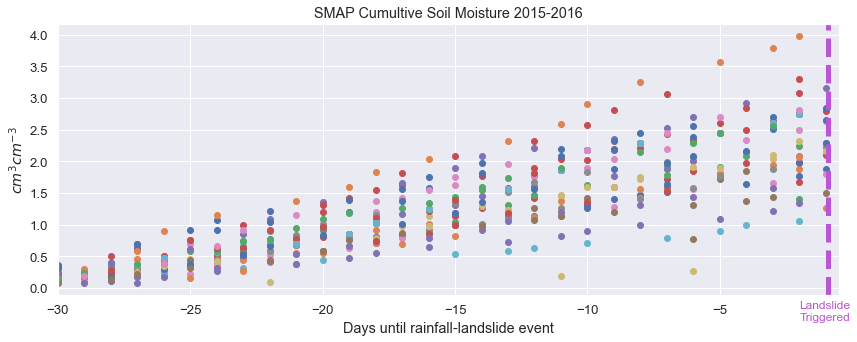

In [14]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in soilm_df.groupby("landslideID"):
    ax.plot(df['days-to-landslide'], df['sm_accum'],
            marker='o', linestyle='none')

# ax.invert_xaxis()
ax.axvline(x=-0.9, ymin=0, color='mediumorchid',
           linestyle='dashed', linewidth=5)
ax.set_xlim([-30, -0.5])
ax.set(xlabel='Days until rainfall-landslide event',
       ylabel='$cm^3 cm^{-3}$',
       title='SMAP Cumultive Soil Moisture 2015-2016')
ax.text(-2, -0.5, 'Landslide\nTriggered', color='mediumorchid', fontsize='large');

## NASA GPM IMERG daily precipitation initiated at co-located with Colorado Landslide events
### (create the same time series as for soil moisture)

#### Read the GPM data that I had already created from daily global netCDF files. The process took a lot of memory that I decided rather than include the processing, to create the final data product in another jupyter notebook and import it here.

In [15]:
gpm_nc = os.path.join('capstone', 'gpm', 'gpm_2006-2016_saved_on_disk.nc')
gpm_xr = xr.open_dataset(gpm_nc).squeeze()
print(gpm_xr.dims)

Frozen({'lon': 76, 'lat': 45, 'time': 3651, 'bnds': 2})


#### Calculate the nearest-neighbor precipitation going back 30 days from each Landslide event

In [16]:
gpm_precip_df = colocate_gpm_to_landslide(glc_co_gt2015, gpm_xr, periods=30)

#### Add a count of 30 days of precipitation measurements for each landslide event. This will help in plotting.

In [17]:
gpm_precip_df = add_count(gpm_precip_df, 30, 'precipitationCal')

#### Add a new column of the cumulative amounts per landslide event

In [18]:
gpm_precip_df = cumulative_var(gpm_precip_df, 'precipitationCal')
gpm_precip_df.head()

,landslideDate,precipitationCal,days-to-landslide,precipitationCal_accum
landslideID,,,,
6994,2015-04-27,0.143790,-30,4.404242
6994,2015-04-27,0.068229,-29,30.722517
6994,2015-04-27,0.004842,-28,34.887558
6994,2015-04-27,0.022953,-27,207.142395
6994,2015-04-27,0.090758,-26,208.919189


#### Plot cumulative precipitation going back 30 days from an landslide

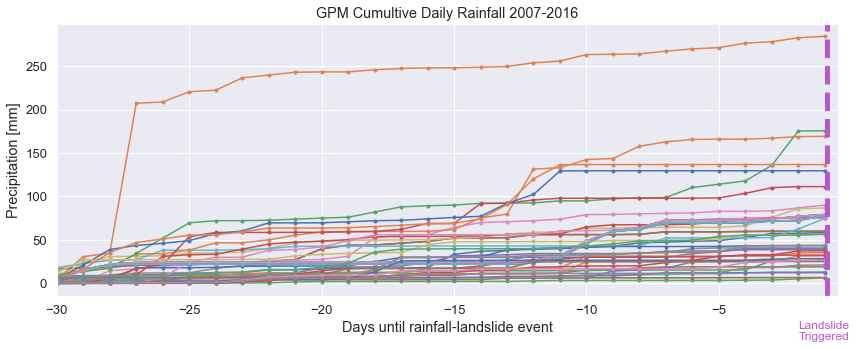

In [19]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in gpm_precip_df.groupby("landslideID"):
    ax.plot(df['days-to-landslide'], df['precipitationCal_accum'], marker='.')

#ax.invert_xaxis()
ax.axvline(x=-0.9, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)
ax.set_xlim([-30,-0.5])
ax.set(xlabel='Days until rainfall-landslide event',
       ylabel='Precipitation [mm]',
       title='GPM Cumultive Daily Rainfall 2007-2016')
ax.text(-2,-65, 'Landslide\nTriggered', color='mediumorchid', fontsize='large');


## Plot soil moisture and precipitation statistics 

In [20]:
soilm_stats_df = soilm_df.groupby('landslideID').agg(
    {'sm': ['mean', 'min', 'max', 'median']})
soilm_stats_df.columns = soilm_stats_df.columns.map('-'.join)

gpm_precip_stats_df = gpm_precip_df.groupby('landslideID').agg(
    {'precipitationCal': ['min', 'max', 'mean', 'median']})
gpm_precip_stats_df.columns = gpm_precip_stats_df.columns.map('_'.join)
gpm_precip_stats_df.head(), soilm_stats_df.head()

(             precipitationCal_min  precipitationCal_max  \
 landslideID                                               
 6940                     0.000000            172.254837   
 6994                     0.000000              1.404012   
 7047                     0.000000              7.465425   
 7048                     0.039176             21.339108   
 7051                     0.000000              8.035460   
 
              precipitationCal_mean  precipitationCal_median  
 landslideID                                                  
 6940                      9.481829                 2.186915  
 6994                      0.206111                 0.038677  
 7047                      1.358137                 0.616643  
 7048                      3.003243                 1.460310  
 7051                      1.293981                 0.256816  ,
               sm-mean    sm-min    sm-max  sm-median
 landslideID                                         
 6940         0.144474  0.10

#### Plot the distributions

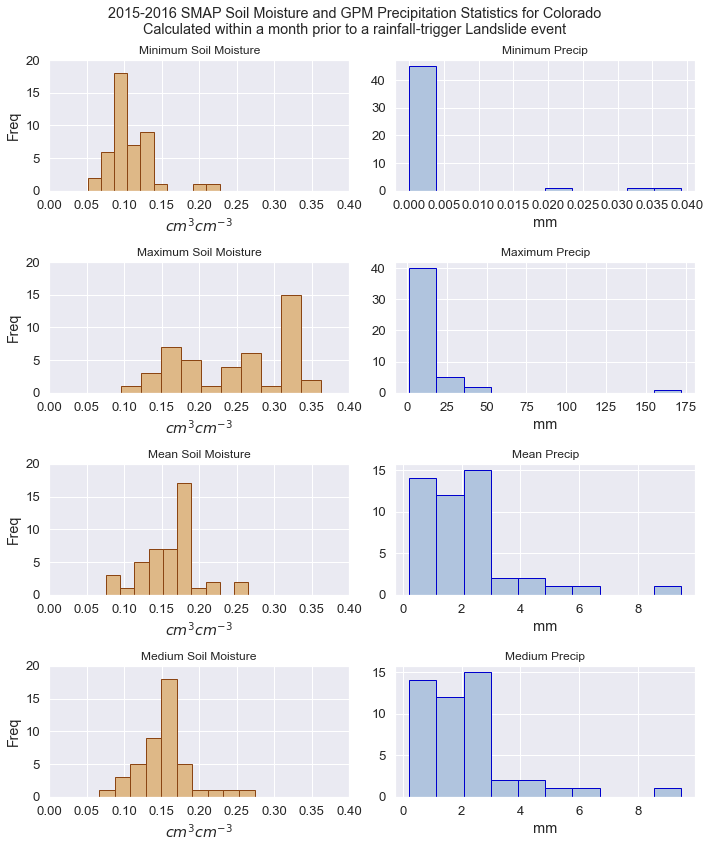

In [21]:
fig, ((ax1, ax2), (ax3, ax4),
      (ax5, ax6), (ax7, ax8)) = plt.subplots(ncols=2, nrows=4,
                                             figsize=(10, 12))

sns.set(font_scale=1.)

# Add overall figure title
tit1 = '2015-2016 SMAP Soil Moisture and GPM Precipitation Statistics for Colorado'
tit2 = 'Calculated within a month prior to a rainfall-trigger Landslide event'
fig.suptitle(tit1+'\n'+tit2)


# The histogram of the data
soilm_stats_df['sm-min'].hist(ax=ax1,
                              color='burlywood', edgecolor='saddlebrown')
gpm_precip_stats_df['precipitationCal_min'].hist(ax=ax2,
                                color='lightsteelblue', edgecolor='mediumblue')


soilm_stats_df['sm-max'].hist(ax=ax3,
                              color='burlywood', edgecolor='saddlebrown')
gpm_precip_stats_df['precipitationCal_max'].hist(ax=ax4,
                                color='lightsteelblue', edgecolor='mediumblue')


soilm_stats_df['sm-mean'].hist(ax=ax5,
                               color='burlywood', edgecolor='saddlebrown')
gpm_precip_stats_df['precipitationCal_mean'].hist(ax=ax6,
                                color='lightsteelblue', edgecolor='mediumblue')

soilm_stats_df['sm-median'].hist(ax=ax7,
                                 color='burlywood', edgecolor='saddlebrown')
gpm_precip_stats_df['precipitationCal_mean'].hist(ax=ax8,
                                color='lightsteelblue', edgecolor='mediumblue')

ax1.set(xlabel='$cm^3 cm^{-3}$', ylabel='Freq',
        title='Minimum Soil Moisture',
        xlim=(0, 0.4), ylim=(0, 20))
ax2.set(xlabel='mm', title='Minimum Precip')
ax3.set(xlabel='$cm^3 cm^{-3}$', ylabel='Freq',
        title='Maximum Soil Moisture',
        xlim=(0, 0.4), ylim=(0, 20))
ax4.set(xlabel='mm', title='Maximum Precip')

ax5.set(xlabel='$cm^3 cm^{-3}$', ylabel='Freq',
        title='Mean Soil Moisture',
        xlim=(0, 0.4), ylim=(0, 20))
ax6.set(xlabel='mm', title='Mean Precip')

ax7.set(xlabel='$cm^3 cm^{-3}$', ylabel='Freq',
        title='Medium Soil Moisture',
        xlim=(0, 0.4), ylim=(0, 20))
ax8.set(xlabel='mm', title='Medium Precip')


fig.tight_layout()

## Observations

The take home is that it doesn't take much precipitation for a landslide occur. The soil is already quite dry and the cumulative plots show that moisture tends to plateau within 10 days of a landslide - which may indicate saturation. My initial thoughts are that the ecosystem is fragile either from land degradation due to vegetation loss and mis-management of land resources, or the earth is drying due to climate change, or all of the above. More in-depth study need to be done. 

## Next Steps

- Correlations! 
- Additional SMAP products to consider:
    - albedo, clay fraction, surface temperature, vegetation opacity, vegetation water content
- Include Landsat NMDI, GRACE groundwater & soil moisture 
- Add the modeling evaluation component
